# "Where is Forest Gain Happening?" Widget

This widget is a mix of a donut chart and a ranked list, similar to the previous extent ranking widget. It shows tree cover gain by admin region. On hover the pie chart segments display the gain, in ha, for that region.

The donut chart should display data for the top few admin regions, and group the rest together as 'Other Districts'.

Displayed data, ordered by DESC area(ha). 

1. Admin-2 or -1 name
2. % of total extent
3. Area of extent (ha)

User Variables:

1. Hanson extent ('Gadm28'), IFL2013, Plantations or Intact forest
2. Admin-0 and -1 region

In [1]:
#Import Global Metadata etc

%run '0.Importable_Globals.ipynb'

In [2]:
# VARIABLES

location = 'All Region'   # 'plantations', 'ifl_2013', or 'primary_forests'... here 'gadm28'=default
threshold = 0             # 0,10,15,20,25,30,50,75,100 
adm0 = 'GBR'
adm1 = 1            # To rank admin 1 areas, set to None
                      # To rank admin 2 areas, specify an admin 1 level
extent_year = 2000 #Extent data (2000 or 2010)

tags = ["forest_change"]
selectable_polynames = ['gadm28',
                        'mining',
                        'plantations']


In [3]:
# get admin 1 or 2 level human-readable name info as needed:
adm1_to_name = None
adm2_to_name = None

if adm1:
    
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    adm2_to_name ={}
    for row in tmp:
        adm2_to_name[row.get('adm2')] = row.get('name')

tmp = get_admin1_json(iso=adm0)
adm1_to_name={}
for row in tmp:
    adm1_to_name[row.get('adm1')] = row.get('name') 

In [4]:
# Returns json object containing admin-codes, total area and extent (both in ha)
# If adm1 is not specified, it returns the total values for each adm1 region
# Else, returns the adm2 values within that adm1 region
# You may also specify a polyname (intersecting area) e.g. 'extent and % of plantations only'
# By default polyname is 'gadm28' (all forest extent)

def multiregion_gain_queries(adm0, adm1=None, p_name='gadm28', threshold=30):
    if adm0 and not adm1:
        print('Request for adm1 areas')
        sql = ("SELECT adm1 as region, sum(area_gain) as gain, sum(area_gadm28) as total "
               f"FROM {ds} "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}' "
               f"GROUP BY adm1 "
               f"ORDER BY adm1")
    elif adm0 and adm1:
        print('Request for adm2 areas')
        sql = ("SELECT adm2 as region, area_gain as gain, area_gadm28 as total "
                f"FROM {ds} "
                f"WHERE iso = '{adm0}' "
                f"AND thresh = {threshold} "
                f"AND polyname = '{p_name}' "
                f"AND adm1 = '{adm1}' ")
    return sql

In [5]:
# Takes the data from the above api call and generates a list containing the relevant data: 
# Admin-Code, Forest Extent Area, Percentage of Admin region
# NOTE that 'area_percent' is the forest extent area relative to teh area of its admin-region.

def data_output(data, adm1=None):
    
    output = []
    for d in range(0, len(data)):
        tmp_ = {

            'region': data[d]['region'],
            'area_gain_percent': (100*data[d]['gain']/data[d]['total']),
            'area_gain_ha': data[d]['gain']

        }
        output.append(tmp_)

    return output

In [6]:
# Example sql and returned data


url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = multiregion_gain_queries(adm0, adm1, polynames[location], threshold)


properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

data = r.json()['data']

data[0:3]

Request for adm2 areas
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm2+as+region%2C+area_gain+as+gain%2C+area_gadm28+as+total+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27GBR%27+AND+thresh+%3D+0+AND+polyname+%3D+%27gadm28%27+AND+adm1+%3D+%271%27+
Status: 200


[{'_id': 'AWB6gnoshRfkUZCTinkq',
  'gain': 1494.37911434,
  'region': 83,
  'total': 319038.138828},
 {'_id': 'AWB6gnoshRfkUZCTinkt',
  'gain': 1103.33419015,
  'region': 86,
  'total': 164255.162317},
 {'_id': 'AWB6gnoshRfkUZCTinkv',
  'gain': 1.06005759146,
  'region': 88,
  'total': 6566.15341402}]

In [7]:
# After generating list return wanted metrics
# (NOTE! This is not sorted.)

gain_json = data_output(data, adm1)
gain_json[0:3]


[{'area_gain_ha': 1494.37911434,
  'area_gain_percent': 0.468401401735123,
  'region': 83},
 {'area_gain_ha': 1103.33419015,
  'area_gain_percent': 0.6717196431370898,
  'region': 86},
 {'area_gain_ha': 1.06005759146,
  'area_gain_percent': 0.016144270848082426,
  'region': 88}]

In [8]:
#Sort regions by area of loss (DESC)

newlist = sorted(gain_json, key=lambda k: k['area_gain_ha'], reverse=True) 
newlist[0:3]


[{'area_gain_ha': 10347.3066765,
  'area_gain_percent': 2.045651543674968,
  'region': 71},
 {'area_gain_ha': 5224.37817512,
  'area_gain_percent': 0.7620487396510351,
  'region': 18},
 {'area_gain_ha': 5154.67946192,
  'area_gain_percent': 0.6467029508515596,
  'region': 69}]

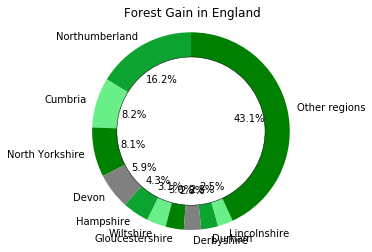

In [9]:
# Example donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
  
limit = 0
sizes = []
labels = [] 

for r in range(0,10):
    
    try:
        if adm1:
            labels.append(adm2_to_name[newlist[r].get('region')])
        elif adm0:
            labels.append(adm1_to_name[newlist[r].get('region')])
        sizes.append(newlist[r].get('area_gain_ha'))
        
    except:
        break
    limit += 1
      
other_regions=0

for rows in range(limit+1,len(newlist)):
    other_regions += newlist[rows].get('area_gain_ha')

if other_regions != 0:
    labels.append('Other regions')
    sizes.append(other_regions)
            
if adm1:
    title = adm1_to_name[adm1]
elif adm0:
    title = iso_to_countries[adm0]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title(f'Forest Gain in {title}')
plt.show()

<a id='s14'></a>
### Dynamic Sentence for "Where is forest gain Located?" Widget

1. Returns the no of regions responsible for >50% of the regions tree cover extent (adm1)
     - or, the extent (%) that the top 10% of regions are responsible for (adm2)
2. Max and Min extent (%) in that region
3. Average extent (%) that each region contributes to the total

In [10]:
#Calculate total three cover loss at this threshold
total = 0

for i in range(0,len(gain_json)):
    total += newlist[i]['area_gain_ha']

In [11]:
# Calculate % extent for the sub-region (relative to total extent) Also filters out incorrect/duplicated data

correct_list = []
for i in range(0,len(gain_json)):
    if(i != 0 and newlist[i]['region'] != newlist[i-1]['region']):
        correct_list.append(100*newlist[i]['area_gain_ha']/total)
    elif i == 0:
        correct_list.append(100*newlist[i]['area_gain_ha']/total)
correct_list[0:3]

[15.831588269839779, 7.993404160164861, 7.886763720790806]

In [12]:
#Calculate the mean extent

mean=0
for i in range(0, len(correct_list)):
    
    mean += correct_list[i]
    
mean = mean/len(correct_list)

In [13]:
# Percentile calcs: work out how many regions are responsible for >50% loss
# x is no. of adm regions.
tenth_percentile = int(len(correct_list)/10)
if adm1:
    top_ten_index = tenth_percentile
    total = np.sum(correct_list[0: top_ten_index+1])
     
accumulated_percent = 0
for n, item in enumerate(correct_list):
    accumulated_percent += item
    if accumulated_percent >= 50:
        lower_fity_percentile_regions = n +1
        break

In [14]:
#Extent Stats
gain_stats = { 'max': correct_list[0], 'min': correct_list[len(correct_list)-1], 'avg': mean}
gain_stats

{'avg': 0.892857142857143, 'max': 15.831588269839779, 'min': 0.0}

In [15]:
#Dynamic sentence. For adm2.

if adm1:
    if len(correct_list) > 10:
        print(f"The top {tenth_percentile} sub-regions were responsible for ", end="")
        print(f"{total:,.0f}% of {adm1_to_name[adm1]}'s ", end="")

        if location == 'All Region':
            print(f"regional tree cover gain. ", end="")
        elif (location == 'Mining' or 'Mining in Intact Forest Landscapes' or 'Mining in Plantation Areas'):
             print(f"treecover gain in areas with {location.lower()}. ", end="")
        else:
            print(f"tree cover gain found in {location.lower()}. ", end="")
   
    print(f"{adm2_to_name[newlist[0].get('region')]} experienced the largest relative treecover gain ", end="")
    print(f"in {adm1_to_name[adm1]} at {gain_stats['max']:,.0f}%, compared to an average ", end="")
    print(f"of {gain_stats['avg']:,.1f}%. ", end="")
    
    
else:
    
#Dynamic sentence. For adm1.
    if len(correct_list) > 10:
        print(f"In {iso_to_countries[adm0]}, {lower_fity_percentile_regions} ", end="")
        print(f"regions represent more than half ({accumulated_percent:,.0f}%) ",end="")
        print(f"of all tree cover gain ", end="")
        if location == 'All Region':
            print(f"country-wide. ", end="")
        elif (location == 'Mining' or 'Mining in Intact Forest Landscapes' or 'Mining in Plantation Areas'):
            print(f"in areas with {location.lower()}. ", end="")
        else:
            print(f"found in {location.lower()}. ", end="")
            
    print(f"{adm1_to_name[newlist[0].get('region')]} has the largest relative tree cover gain ", end="")
    print(f"in {iso_to_countries[adm0]} at {gain_stats['max']:,.0f}%, compared to an average ", end="")
    print(f"of {gain_stats['avg']:,.1f}%. ", end="")

The top 11 sub-regions were responsible for 60% of England's regional tree cover gain. Northumberland experienced the largest relative treecover gain in England at 16%, compared to an average of 0.9%. 